## Change to CAFE60v1 bias correction scheme

The bias correction scheme used for CAFE60v1 (which provides the CAFE-f6 initial conditions) was changed at the beginning of 1992 (or thereabouts). Quoting from [O'Kane et al 2021](https://doi.org/10.1175/JCLI-D-20-0974.1):

"Prior to 1992, sea surface temperature (SST) is bias corrected using the method of Evensen (2003, section 4.2.2 therein) (see also O’Kane et al. 2019; Sandery et al. 2020). To estimate the SST bias field, an ensemble of bias fields is initialized to independently identically distributed random spatially uniform values and the observed SST is then assumed to be the sum of the model SST and unknown bias. This field is then updated similar to other model fields and the resulting ensemble of biases is evolved using a first-order autoregressive function [see paper for details]. Further, the SST bias influences subsurface temperature in the mixed layer, and therefore affects innovations from subsurface observations. Bias correction in this form can only detect and correct systematic errors in the initial conditions. Due to the relatively long assimilation window (calendar month), model SST bias was found to grow appreciably with lead time in particular regions and very specifically the South Pacific Ocean during the austral summer. Application of weak (90-day time scale) restoring to an SST climatology constructed from HadISST was applied to the forward model post 1992 to ameliorate the biases replacing the method of Evensen (2003)."

This change has a noticable and lasting impact on the CAFE-f6 forecasts, with forecasts initialised prior to 1992 demonstrating different behaviour than those initialised after 1992.

### Impact on CAFE60 initial conditions
Let's demonstrate the impact of the change in bias-correction scheme for a few monthly ocean variables, for example SST, which clearly shows the bias prior to 1992.

In [1]:
import cftime

import xarray as xr

from distributed import Client

from src import utils

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [3]:
d60_ocean = xr.merge(
    [
        xr.open_zarr("../data/raw/CAFE60v1/ocean_month.zarr.zip"),
        xr.open_dataset("../data/raw/gridinfo/CAFE_ocean_grid.nc")[["area_t"]],
    ]
)

had = xr.open_zarr("../data/raw/HadISST/ocean_month.zarr", use_cftime=True)
had = had.where(had > -1000)
had = xr.merge([had, utils.gridarea_cdo(had).rename("area")])

with Client() as client:
    sst_gbl = (
        d60_ocean["sst"]
        .mean("ensemble")
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

    had_gbl = had["sst"].weighted(had["area"]).mean(["longitude", "latitude"]).compute()

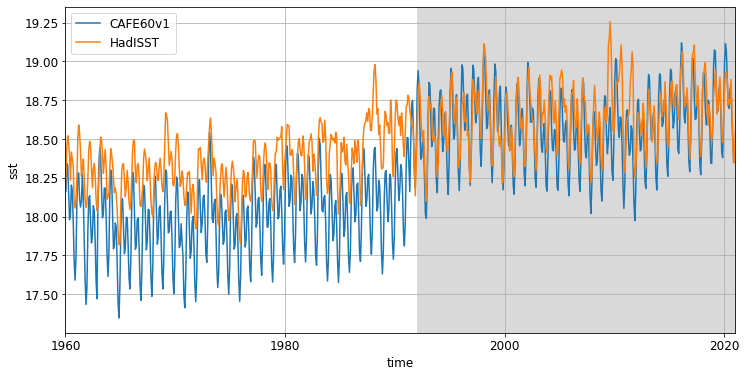

In [4]:
def shading(ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    trans = cftime.datetime(1992, 1, 1)
    end = cftime.datetime(2030, 1, 1)
    ax.fill_between(
        [trans, end], [ylim[1], ylim[1]], [ylim[0], ylim[0]], color=[0.85, 0.85, 0.85]
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


sst_gbl.plot(label="CAFE60v1")
had_gbl.plot(label="HadISST")
ax = plt.gca()
shading(ax)
ax.legend()
ax.grid()
_ = plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2021, 1, 1))

The change in bias correction scheme appears to induce a significant response in, for example, ocean temperature and salinity in the years following the change, particularly in the subsurface. Temperature increases and salinity decreases until the early 2000s, when increases in assimilated subsurface ocean observations presumably start to bring these variables back in line.

In [5]:
with Client() as client:
    ocean_gbl = (
        d60_ocean[["temp", "salt"]]
        .mean("ensemble")
        .chunk({"st_ocean": -1})
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

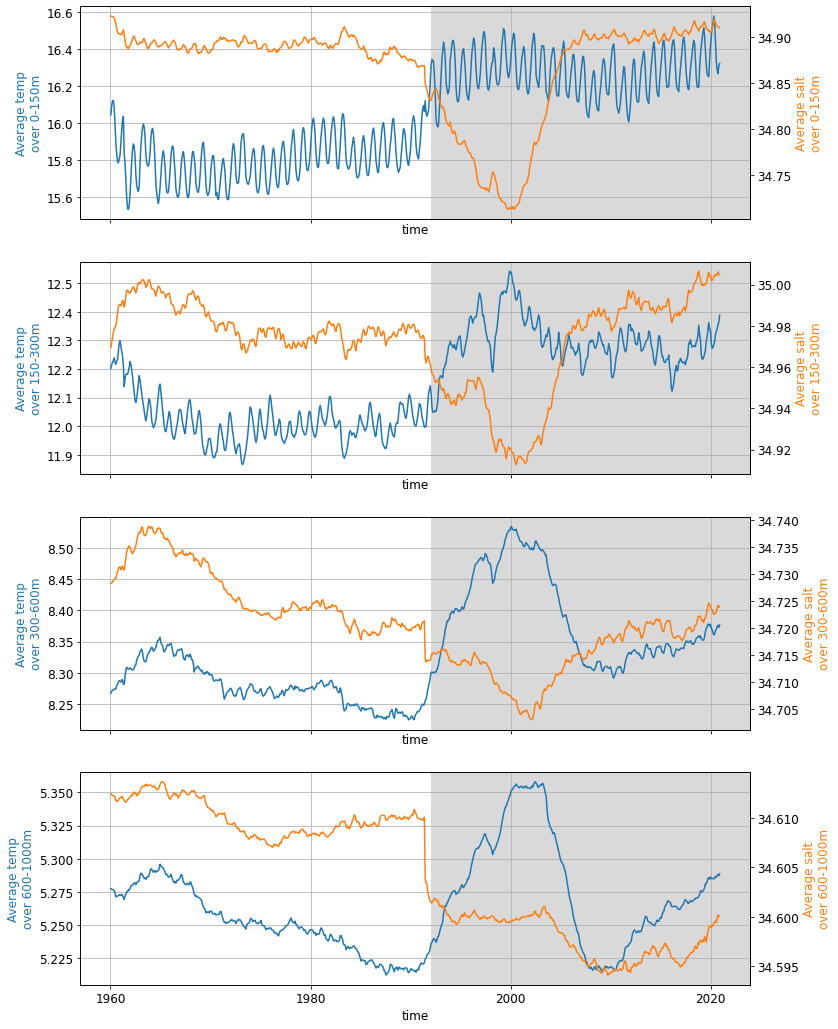

In [6]:
depth_ranges = [slice(0, 150), slice(150, 300), slice(300, 600), slice(600, 1000)]

fig, axs = plt.subplots(
    len(depth_ranges),
    1,
    figsize=(12, 18),
    sharex=True,
)

for i, r in enumerate(depth_ranges):
    axt = axs[i].twinx()
    d = ocean_gbl.sel(st_ocean=r).mean("st_ocean")
    d["temp"].plot(ax=axs[i], color="C0")
    d["salt"].plot(ax=axt, color="C1")
    shading(axs[i])
    axs[i].grid()
    axs[i].set_ylabel(f"Average temp\nover {r.start}-{r.stop}m", color="C0")
    axt.set_ylabel(f"Average salt\nover {r.start}-{r.stop}m", color="C1")

The step change observed in `salt` between 1991-05 and 1991-06 is the result of manually adding an offset (~1m) to the sea surface height after it was discovered that CAFE60v1 had been systematically losing water since it was started in 1960. This does not appear to be described in [O'Kane et al 2021](https://doi.org/10.1175/JCLI-D-20-0974.1) (see above for reference):

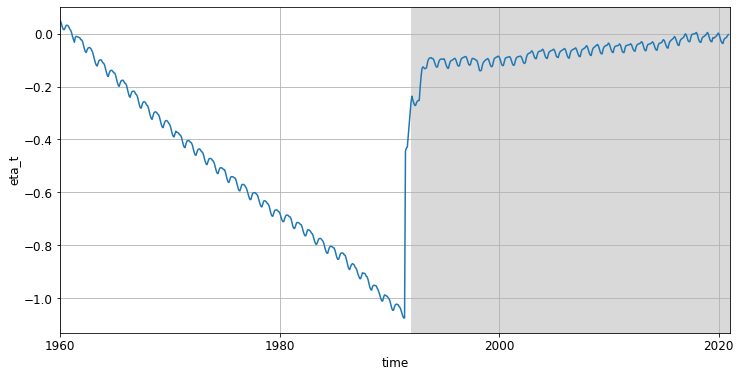

In [7]:
with Client() as client:
    ssh_gbl = (
        d60_ocean["eta_t"]
        .mean("ensemble")
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

ssh_gbl.plot()
ax = plt.gca()
shading(ax)
ax.grid()
_ = plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2021, 1, 1))

The change due to the change in bias correction scheme is also very apparent in atmospheric variables, even though the bias-correction scheme is only applied to SST.

In [8]:
d60_atmos = xr.merge(
    [
        utils.truncate_latitudes(
            xr.open_zarr("../data/raw/CAFE60v1/atmos_isobaric_month.zarr.zip")
        ),
        xr.open_dataset("../data/raw/gridinfo/CAFE_atmos_grid.nc")[["area"]],
    ]
)

with Client() as client:
    atmos_gbl = (
        d60_atmos[["precip", "t_ref"]]
        .mean("ensemble")
        .chunk({"time": -1})
        .weighted(d60_atmos["area"])
        .mean(["lon", "lat"])
        .compute()
    )

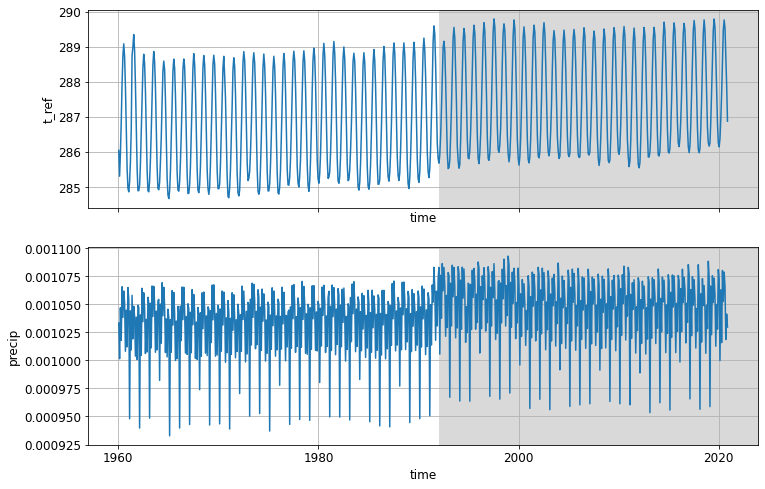

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

atmos_gbl["t_ref"].plot(ax=axs[0])
atmos_gbl["precip"].plot(ax=axs[1])
shading(axs[0])
shading(axs[1])
axs[0].grid()
axs[1].grid()

### Impact on CAFE-f6 forecasts
CAFE60v1 provides the initial conditions for the CAFE-f6 forecasts and so the change in bias correction scheme is also evident in the forecasts. The following shows annual-average November-initialised forecasts of various quanities. All show an apparent difference between forecasts initialised before and after 1992.

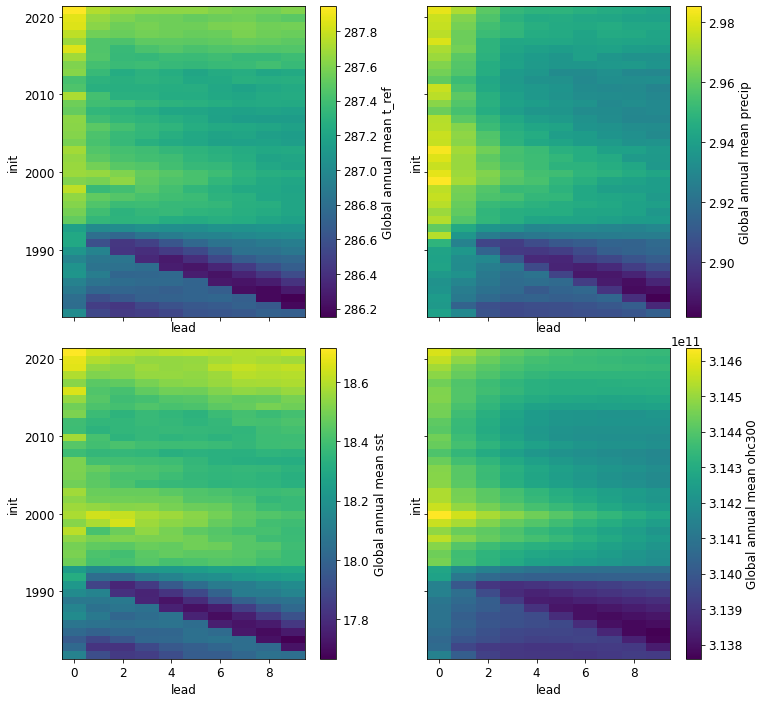

In [10]:
variables = ["t_ref", "precip", "sst", "ohc300"]

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()

for i, v in enumerate(variables):
    ds = xr.open_zarr(f"../data/processed/CAFEf6.annual.full.{v}_global.zarr")
    da_gbl = ds.mean("member").weighted(ds["area"]).mean(["lon", "lat"])[v]
    da_gbl = da_gbl.assign_coords({"lead": ((da_gbl.lead - 11) / 12).astype(int)})
    da_gbl.rename(f"Global annual mean {da_gbl.name}").plot(ax=axs[i])

plt.subplots_adjust(wspace=0.2, hspace=0.1)

A few simple approaches were tried for removing this discrepancy, but none were very successful.